D'abord les imports

In [44]:
import numpy as np
import scipy as sp

import pygeomphase as pgp
import bispy as bsp
import quaternion

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

#from tqdm import tqdm

Paramètre du signal


/!\ Super important : si theta est modifier, il faudra aussi modifier la formule de theta' dans le calcul d'intégrale !!!

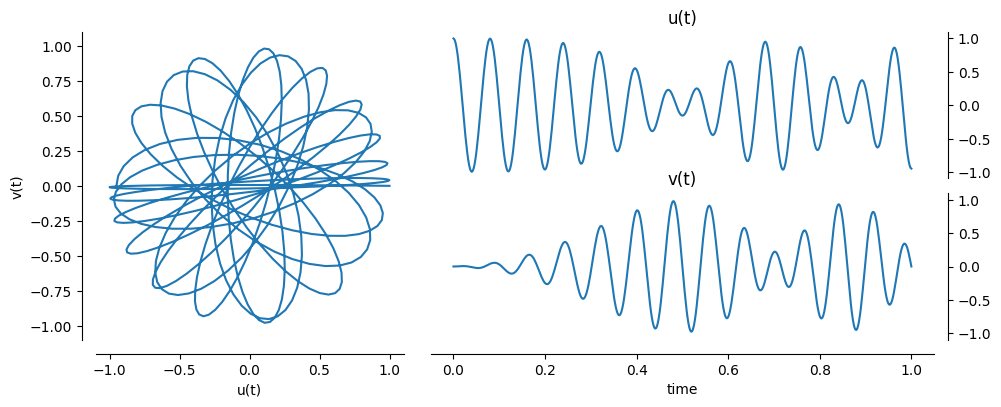

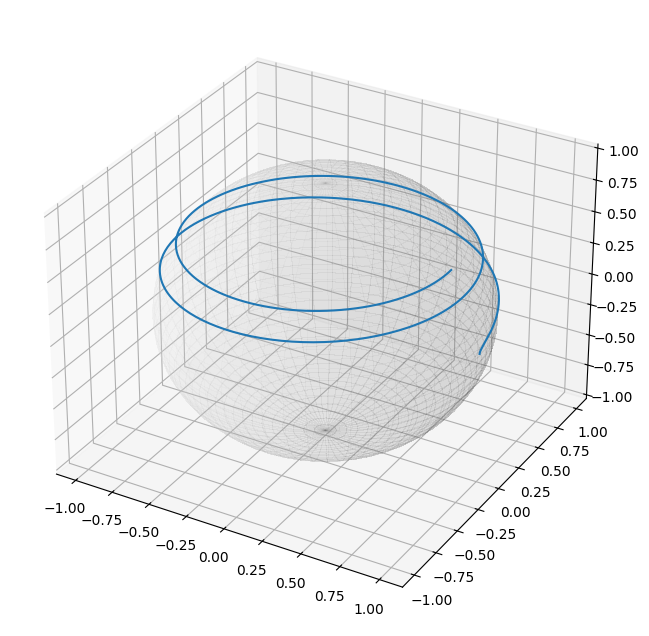

In [45]:
    # Pas de temps

L = 1#5                     # durée du signal
N = 500                     # nombre de mesures par unité de temps
t = np.linspace(0, L, L*N)  # array des temps


    # Paramètres du signal (ampli, phase, ...)

a = np.ones_like(t)

def phi_f(t):
    return 25 * np.pi * t

def theta_f(t):
    return 2*np.pi  * t**2

def theta_p(t): #theta prime, ca dérivée en somme
    return 4*np.pi * t

def chi_f(t):
    return np.pi/10 * t

# valeurs associées aux fonctions
phi  =  np.array([phi_f(t_) for t_ in t])
theta  =  np.array([theta_f(t_) for t_ in t])
chi  =  np.array([chi_f(t_) for t_ in t])


    # Construction du signal

env = a
#env = bsp.utils.windows.hanning(L*N)

x = bsp.signals.bivariateAMFM(env, theta, chi, phi)

# en fonction des paramètres de Stokes
S0, S1, S2, S3 = bsp.utils.geo2Stokes(a, theta, chi)
#print(f'{x = }\n')

# comme vecteur complexe
x1, x2 = bsp.utils.sympSplit(x)
xvec = np.array([x1, x2])


    # Plots

# en 2D

bsp.utils.visual.plot2D(t, x)
plt.show() 


# en 3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

# ajout de la sphère
u, v = np.mgrid[0 : 2 * np.pi : 50j, 0 : np.pi : 50j]
r1 = np.cos(u) * np.sin(v)
r2 = np.sin(u) * np.sin(v)
r3 = np.cos(v)

r = 0.99
ls = LightSource(azdeg=210, altdeg=30)
ax.plot_surface(r * r1, r * r2, r * r3, color=(0.9, 0.9, 0.9), alpha=0.1, zorder=-1, rstride=1, cstride=1, linewidth=0, antialiased=False)

# plot du signal sur la sphère
ax.plot(S1/S0, S2/S0, S3/S0)
plt.show()

Calcul des la phases géométrique avec différentes formules

In [46]:
    # Calcul façon Bargmann (normalisé ou non)

# la "vraie" phase g
phig_b = -np.angle(pgp.bargmann_invariant(xvec))
phig_b2 = -np.angle(pgp.bargmann_invariant_unnormalized(xvec))

print(f'\n{phig_b =} \n{phig_b2 =} \n {xvec.shape = }\n')



phig_b =array([-0.00000000e+00,  6.12781807e-18, -3.17728691e-08, -1.27090817e-07,
       -3.17724719e-07, -6.35443402e-07, -1.11201289e-06, -1.77919557e-06,
       -2.66874927e-06, -3.81242626e-06, -5.24197212e-06, -6.98912443e-06,
       -9.08561139e-06, -1.15631502e-05, -1.44534454e-05, -1.77881865e-05,
       -2.15990463e-05, -2.59176781e-05, -3.07757132e-05, -3.62047576e-05,
       -4.22363892e-05, -4.89021539e-05, -5.62335617e-05, -6.42620829e-05,
       -7.30191428e-05, -8.25361175e-05, -9.28443279e-05, -1.03975034e-04,
       -1.15959430e-04, -1.28828636e-04, -1.42613690e-04, -1.57345544e-04,
       -1.73055053e-04, -1.89772967e-04, -2.07529922e-04, -2.26356430e-04,
       -2.46282871e-04, -2.67339478e-04, -2.89556328e-04, -3.12963331e-04,
       -3.37590216e-04, -3.63466517e-04, -3.90621560e-04, -4.19084448e-04,
       -4.48884044e-04, -4.80048958e-04, -5.12607528e-04, -5.46587800e-04,
       -5.82017514e-04, -6.18924082e-04, -6.57334567e-04, -6.97275663e-04,
       -7.387736

0 - phig_formule[i] = 0.0 0.0
l'arctan va bien ? True
100 - phig_formule[i] = 0.01625254221467075 0.3293357857578051
l'arctan va bien ? True
200 - phig_formule[i] = 0.1986030298546854 1.261577953894841
l'arctan va bien ? True
300 - phig_formule[i] = 2.9185280025924474 -4.952569175660662
l'arctan va bien ? False
400 - phig_formule[i] = -2.8305888698209793 -4.0118249851259895
l'arctan va bien ? False


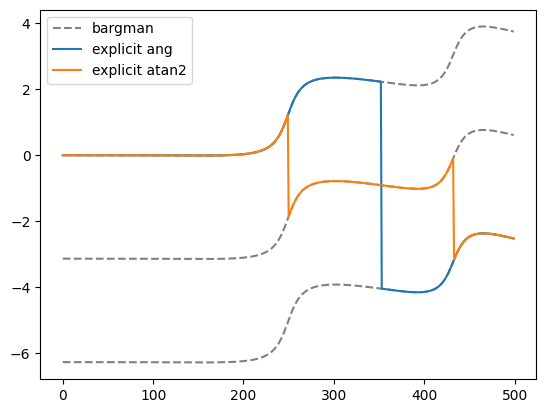

In [47]:
    # Avec la formule du stagière

# calcul le terme dans la phase totale   
def terme_entro(i, theta, chi, arg=True):
    Dtheta = theta[i]-theta[0]
    Dchi = chi[i]-chi[0]
    Schi = chi[i]+chi[0]

    # version (arg)1
    if arg :
        bb = np.cos(Dtheta) * np.cos(Dchi) + 1j * (np.sin(Dtheta) * np.sin(Schi))
        return np.angle(bb)
    # version (atan)2
    else :
        num = np.tan(Dtheta) * (np.tan(chi[i]) + np.tan(chi[0]))
        den = 1 + np.tan(chi[i])*np.tan(chi[0])
        return np.atan2(num, den)

# calcul itératif de la phase géométrique
phig_arg = np.empty_like(t)
phig_tan = np.empty_like(t)

for i,t_ in enumerate(t) :
    # terme intégrale dans la phase dynamique
    phig_arg[i] = -sp.integrate.quad(lambda s: (theta_p(s) * np.sin(2*chi_f(s))), t[0], t_)[0]
    phig_tan[i] = phig_arg[i]
    # et du terme en arctan dans la phase total
    plus1 = terme_entro(i, theta, chi, arg=True)
    plus2 = terme_entro(i, theta, chi, arg=False)

    # somme des deux avec print
    if i%100 == 0:
        print(f'{i} - phig_formule[i] = {plus1} {phig_formule[i]}')
        print(f"l'arctan va bien ? {np.allclose(plus1, plus2)}")

    phig_arg[i] += plus1
    phig_tan[i] += plus2


    # Plot des 3

#print(f'{phig1=}')
#print(f'{phig2=}')
#print(f'{phig_formule=}')

plt.plot(np.unwrap(phig_b), label='bargman', color='gray', ls='--')
plt.plot(np.unwrap(phig_b - np.pi), color='gray', ls='--')
plt.plot(np.unwrap(phig_b - 2*np.pi), color='gray', ls='--')
#plt.plot(phig_b, label='bargmann unnmz')

plt.plot(phig_arg, label='explicit ang')     # np.unwrap(phig_arg, np.pi)
plt.plot(phig_tan, label='explicit atan2')     # np.unwrap(phig_formule, np.pi)
plt.legend()
plt.show()


